# Worldpay Traffic Accident Analysis

## Background:

'2014 Road Safety - Accidents 2014' contains data about circumstances of various road traffic accidents reported to police (geographical location, type of roads, #vehicles involved, etc.) It also contains data about police involvement (regional police force and if police officer attended the incident. The goal of this notebook was to create a model, which based on other variables would be able to predict if police officer will attend an accident or not.

## Results summary:

 - We produced an ensemble of gradient boosted trees. It had gini index of 0.508 (AUC 0.754) on validation sets.
 - There were some challenges along the way. Two important ones were unbalanced class sizes of the target variable (82% of incidents in the data were attended by police) and high cardinality categorical features.
 - In general geographical location (latitude/longitude) had biggest importance on attendence probability. We found some other interesting patterns in the data:
     - incidents around roundabouts tend to be less attended.
     - incidents on Mondays tend to be more attended.
     - incidents in rural areas tend to be more attended (or more likely less serious incidents in rural areas are not reported).
 - Usefulness of model produced depends on how we want to use it, but in general it was tough to predict police attendence. Depending on sensitivity final model could have precision of ~40% with recall of ~60% for predicting which accidents police will not attend.
 - There are quite a few things to do to improve our final model. We have not done any hyperparameter tuning. Smarter categorical variable encodings and feature engineering could help. Using more and different data could help (we only used data for 2014, there is also data about the vehicles involved).

## Data preprocessing:



We did some basic feature engineering extracting month and day of the year from date column as well as hour from time columns. We also removed redundant columns (Easting, Northing) as well as LSOA_area codes as this feature had very high cardinality and there was no way to combine the categories. In general we had quite a few categorical features with high cardinality and as we used tree models One Hot encoding seemed like a bad idea. We went on to replace categorical features with weighted sum of average police unatendence rate for each category and general unatendence rate of 18% depending on number of samples in category. This encoding produced an improvement working with RandomForests (gini increase from 0.444 to 0.454) but did not work that well on boosted trees. We ended up using raw unencoded features with boosted trees. As target unbalancedness proved to be an issue we also upsampled data corresponding to points with no police attendance by 100%. 

## Algorithms used:

As dataset was not balanced with only 18% of accidents not attended by police, determining accidents not attended by police was the main challenge. Furthermore looking at how different features correlate with target variable (and particularly with no police attendance) we did not see any particularly strong relationships. There were no sizable (> 2500 datapoints) feature categories with >30% of unattended accidents. With this and limited time for the task in mind we decided to go for tree ensemble methods which we hoped would pick up deeper interactions between the variables. We tried RandomForestClassifier from sklearn library and XGBClassifier from xgboost library. Unsurprisingly boosted tree outperformed bagged trees and we ended up with model producing the following ROC curve with gini index of 0.508 (AUC 0.754) on hold out sets using 5-fold cross validation:

![title](img/ROC.png)

Using 0.5 probability threshold we got following confusion matrix:

[[92671 26936]<br>
 [11599 15116]]

suggesting ~40% precision with ~60% recall for cases with no police attendence. 

It was not clear how we are planning to use this model and what are the consequences of misclassification for each class. Therefore we used gini index as the main evaluation metric for our indices, giving overall score for our predicted probabilities.

We got the following feature importances:

![title](img/importance.png)

Maybe somewhat surprisingly, lat/long came out at the top (we expected that district and local_authority would probably pick up geographical locations a bit more easily). Day feature was quite up as well. Inspecting its categories we have seen some interesting patterns like high police attendence rate during Christmas and New Year (likely because people report only the most important incidents).

# Analysis and code:

In [157]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)

### Basic look at the data

In [24]:
data = pd.read_csv('data/DfTRoadSafety_Accidents_2014.csv')

We begin by investigating data:

In [69]:
data.tail()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
146317,2014984136414,310037,597647,-3.417278,55.264773,98,2,2,1,07/12/2014,1,22:20,917,S12000006,2,74,3,70,0,-1,-1,0,0,0,6,3,3,0,0,2,1,NaN
146318,2014984137514,321509,574063,-3.230255,55.054855,98,3,2,2,11/12/2014,5,06:40,917,S12000006,2,74,3,70,0,-1,-1,0,0,0,6,1,3,0,0,2,1,NaN
146319,2014984137714,321337,566365,-3.230826,54.985668,98,3,1,1,09/12/2014,3,02:00,917,S12000006,4,721,6,40,0,-1,-1,0,0,0,4,1,4,0,0,2,1,NaN
146320,2014984138414,323869,566853,-3.191397,54.990446,98,2,3,2,17/12/2014,4,06:55,917,S12000006,3,75,6,60,3,4,5,43,0,0,6,2,2,0,0,2,1,NaN
146321,2014984139614,314072,579971,-3.348426,55.106700,98,3,2,2,24/12/2014,4,15:00,917,S12000006,4,723,6,60,3,4,4,7076,0,0,1,1,2,0,0,2,1,NaN


We can see some missing values (both -1 and NaNs), some redundant features: Accident_Index, Eastings and Northings (given with have lat/long), some columns which will need preprocessing (String values, Date and Time). Checking data size and duplicates:

In [70]:
print(data.shape)
data.drop_duplicates()
print(data.shape)

(146322, 32)
(146322, 32)


No duplicates, great! We continue by looking at some descriptive statistics for features and checking variable descriptions at http://data.dft.gov.uk/road-accidents-safety-data/Road-Accident-Safety-Data-Guide.xls:

In [73]:
data.describe()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident
count,146322.000000,1.463220e+05,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000,146322.00000,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000
mean,447029.362475,2.903741e+05,-1.328712,52.500882,29.895839,2.836033,1.835179,1.329103,4.09868,343.380537,4.077083,1002.119592,5.160796,38.238611,2.333354,1.853200,2.810234,377.446023,0.008386,0.857725,1.924099,1.500595,1.328132,0.096985,0.069135,1.341951,1.182577
std,95158.326674,1.578227e+05,1.397358,1.421337,25.190838,0.399682,0.700208,0.857469,1.91668,258.280727,1.417408,1791.325195,1.644357,13.850167,2.498027,2.339494,3.193163,1288.061037,0.119877,1.947539,1.627001,1.514131,0.568551,0.685515,0.612831,0.474365,0.386320
min,70951.000000,1.030400e+04,-7.450342,49.913077,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,20.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000
25%,384364.250000,1.765900e+05,-2.235527,51.474928,6.000000,3.000000,1.000000,1.000000,2.00000,104.000000,3.000000,0.000000,6.000000,30.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
50%,451306.000000,2.416200e+05,-1.238819,52.055123,30.000000,3.000000,2.000000,1.000000,4.00000,323.000000,3.000000,146.000000,6.000000,30.000000,3.000000,4.000000,4.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,526830.000000,3.911760e+05,-0.170586,53.414623,45.000000,3.000000,2.000000,1.000000,6.00000,517.000000,6.000000,762.000000,6.000000,40.000000,3.000000,4.000000,6.000000,0.000000,0.000000,0.000000,4.000000,1.000000,2.000000,0.000000,0.000000,2.000000,1.000000
max,655309.000000,1.190858e+06,1.758797,60.597984,98.000000,3.000000,21.000000,93.000000,7.00000,941.000000,6.000000,9999.000000,9.000000,70.000000,9.000000,4.000000,6.000000,9999.000000,2.000000,8.000000,7.000000,9.000000,5.000000,7.000000,7.000000,2.000000,2.000000


We can see that 'Did_Police_Officer_Attend_Scene_of_Accident' (our target variable) is always either 1 (yes) or 2 (no), nice as we do not have the third option (No - accident was reported using a self completion  form (self rep only)). From variable descriptions we also see that majority of features are categorical and some of them have very high cardinality. Usual One-Hot encoding might not be the best strategy for preprocessing here.

We carry on by removing removing some of the redundant columns from our dataset and extracting date and time features. We also look at how many accidents were reported for different times of year and day:

In [143]:
Y = data['Did_Police_Officer_Attend_Scene_of_Accident'].map({1: 0, 2: 1})
X = data.drop(['Did_Police_Officer_Attend_Scene_of_Accident', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Accident_Index'], axis=1)

#extract time features
X['Date'] = pd.to_datetime(X['Date'])
X['Month'] = X['Date'].dt.month
X['Day'] = X['Date'].dt.dayofyear
X['Hour'] = X['Time'].str[:2].astype(int)
print(X['Month'].value_counts())
print(X['Day'].value_counts())
print(X['Hour'].value_counts())
X.drop(['Date', 'Time'], axis=1, inplace=True)

10    13021
7     12991
11    12869
1     12830
6     12383
5     12368
8     12359
3     12096
9     11951
4     11585
12    11324
2     10545
Name: Month, dtype: int64
14     567
283    560
132    554
191    545
350    543
224    540
345    538
101    532
318    532
161    531
253    530
8      527
157    522
290    520
222    516
24     516
255    513
69     512
329    510
13     510
183    508
178    507
164    502
328    502
192    500
346    498
322    497
340    495
80     495
353    493
      ... 
117    293
46     291
309    291
338    291
34     286
363    285
111    284
82     283
364    277
320    277
110    276
193    276
33     272
91     272
121    269
361    269
299    268
1      267
355    266
360    265
257    259
245    257
54     253
362    249
19     244
335    242
26     240
155    229
365    223
359    128
Name: Day, Length: 365, dtype: int64
17    13324
16    11924
15    11271
8     10723
18    10529
14     8833
12     8811
13     8716
11     7850
19     7513
9 

We can see fewer accidents reported during holidays like Christmas as well as at night.

We then look at how balanced data set is and how features correlate with target:

In [144]:
print(Y.value_counts())
print('proportion not attended: ' + str(sum(Y)/len(Y)))

0    119607
1     26715
Name: Did_Police_Officer_Attend_Scene_of_Accident, dtype: int64
proportion not attended: 0.182576782712


In 82% of the cases police did attend the accident, so our dataset is not balanced. Quite a few accidents are not reported to police and are missing from our data. We will need to make sure our classifier is able to detect cases where police did not attend the accident and we will need to think about appropriate evaluation metric. 

Looking at which features indicates police might not attend:

### Analysing features

In [145]:
#print proportion of accidents not attended by police for sizeable categories of each variable
X['Y'] = Y

print('informative features indicating police will not attend: ')
for col in [col for col in X.columns if col not in ['Longitude', 'Latitude']]:
    grouped = X.groupby(col)['Y'].agg(['mean', 'count'])
    filtered_cats = grouped[(grouped['mean'] > 0.25) & (grouped['count'] > 2500)]
    if not filtered_cats.empty:
        print(filtered_cats)

informative features indicating police will not attend: 
                  mean  count
Police_Force                 
10            0.256723   3198
16            0.251766   2689
20            0.264680   5603
31            0.255903   2880
                                mean  count
Local_Authority_(District)                 
300                         0.281583   2628
                               mean  count
Local_Authority_(Highway)                 
E08000025                  0.281583   2628
               mean  count
Road_Type                 
1          0.254429  10329
2          0.269165   2935
                 mean  count
Speed_limit                 
20           0.286717   3418
                     mean  count
Junction_Detail                 
1                0.264393  13253
   mean  count
Y             
1     1  26715


We can see some police forces (Northumbria, Humberside, West Midlands, Nottinghamshere) tend to attend fewer incidents. 
Fewer incidents tend to be attended in Birmingham local authority. Also incidents around roundabounts and one-way streets tend to be less attended. Small speed_limit is also indicator of low attendence.

In [146]:
print('informative features indicating police will attend: ')
for col in [col for col in X.columns if col not in ['Longitude', 'Latitude']]:
    grouped = X.groupby(col)['Y'].agg(['mean', 'count'])
    filtered_cats = grouped[(grouped['mean'] < 0.1) & (grouped['count'] > 2000)]
    if not filtered_cats.empty:
        print(filtered_cats)

informative features indicating police will attend: 
                  mean  count
Police_Force                 
4             0.000000   3879
62            0.025773   2328
                       mean  count
Accident_Severity                 
2                  0.093877  20676
                        mean  count
Number_of_Vehicles                 
3                   0.079795  11329
4                   0.036550   2435
                          mean  count
Number_of_Casualties                 
3                     0.067831   6354
4                     0.052561   2245
                           mean  count
Local_Authority_(Highway)             
E10000017                   0.0   3078
                    mean  count
1st_Road_Class                 
1               0.074152   5246
                 mean  count
Speed_limit                 
50           0.088149   5797
60           0.083034  20016
70           0.071946  10077
                      mean  count
Light_Conditions                 


We can see some police forces tend to attend most of the incident (South Wales, Lancashire). 100% incidents in Lancashire were attended by police (either they have different policy there or more likely we are missing some data here). High severity, high number of vehicles involved and people injured, high speed limit are unsurprisingly also indicative of police attending. So are accidents on motorway and in places with no lighting.

In [147]:
print('unfiltered data on attendence: ')
for col in [col for col in X.columns if col not in ['Longitude', 'Latitude']]:
    print(X.groupby(col)['Y'].agg(['mean', 'count']))
    
X.drop('Y', axis=1, inplace=True)

unfiltered data on attendence: 
                  mean  count
Police_Force                 
1             0.174519  25682
3             0.236936   1397
4             0.000000   3879
5             0.185094   2831
6             0.124126   4004
7             0.206135   2673
10            0.256723   3198
11            0.268116   1242
12            0.181238   2036
13            0.194527   5043
14            0.168876   3168
16            0.251766   2689
17            0.240720    889
20            0.264680   5603
21            0.182208   2799
22            0.216588   2327
23            0.142166   1653
30            0.254167   2400
31            0.255903   2880
32            0.163628   2194
33            0.160145   2479
34            0.178324   1301
35            0.215227   2049
36            0.150372   1882
37            0.135150   1761
40            0.196576   1577
41            0.190205   2634
42            0.167598   4117
43            0.178670   5429
44            0.186658   4527
45      

                               mean  count
LSOA_of_Accident_Location                 
E01000001                  0.363636     11
E01000002                  0.125000      8
E01000003                  0.000000      2
E01000005                  0.105263     19
E01000006                  0.000000      2
E01000007                  0.230769     13
E01000008                  0.000000      4
E01000009                  0.200000     10
E01000010                  0.375000      8
E01000011                  0.000000      2
E01000012                  0.333333      3
E01000013                  0.200000     10
E01000014                  0.666667      3
E01000015                  0.000000      5
E01000016                  0.000000      5
E01000018                  0.000000      1
E01000019                  0.000000      3
E01000020                  0.000000      1
E01000021                  0.000000      4
E01000023                  0.142857      7
E01000025                  0.000000      1
E01000027  

Other interesting trends: 
 - accidents on Mondays seem to be better attended by police.
 - unsurprisingly, if road type, light conditions or weather conditions are marked as unknown, police probably did not attend the accident. We should probably remove such data from modeling if we wanted a useful model.
 - surprisingly larger proportion of the rural accidents is attended than urban ones. Probably non-serious rural accidents are just not reported.
 - similarly, larger proportion of accidents is attended during Christmas, New year or at night. But we saw before, that there were also fewer of them reported at those times.
 
All in all it does not look like we have features which strongly correlate with probability of police attendence. Because of this we will try tree ensembles rather than logistic regression in hope that some interactions of variables will be able to pick up accidents not attended by police.
 
Before we start any modelling let's look at missing values:

In [148]:
#count missing values by column:
print(X.apply(lambda x: sum(x == -1), axis=0))
#for Junction_Control, 2nd_Road_Class, Road_Surface_Conditions we can just leave this as separate category
#for Special_Condition_at_Site, Carriageway_Hazards we will just replace it with most common value (it's fine to do it here
#as there is only 1 value missing, otherwise we should do it separately for each cross validation fold)
X.loc[X['Special_Conditions_at_Site'] == -1, 'Special_Conditions_at_Site'] = X['Special_Conditions_at_Site'].mode().iloc[0]
X.loc[X['Carriageway_Hazards'] == -1, 'Carriageway_Hazards'] = X['Carriageway_Hazards'].mode().iloc[0]

Longitude                                      0
Latitude                                       0
Police_Force                                   0
Accident_Severity                              0
Number_of_Vehicles                             0
Number_of_Casualties                           0
Day_of_Week                                    0
Local_Authority_(District)                     0
Local_Authority_(Highway)                      0
1st_Road_Class                                 0
1st_Road_Number                                0
Road_Type                                      0
Speed_limit                                    0
Junction_Detail                                0
Junction_Control                           56467
2nd_Road_Class                             56998
2nd_Road_Number                              616
Pedestrian_Crossing-Human_Control              0
Pedestrian_Crossing-Physical_Facilities        0
Light_Conditions                               0
Weather_Conditions  

Finally we also remove last column 'LSOA_of_Accident_Location' column, as its cardinality is too high. https://en.wikipedia.org/wiki/ONS_coding_system suggests there is not much we can do to combine these categories in any good way and hopefully information stored in here should be captured by lat/long effectively.

In [149]:
#removing LSOA_of_Accident_Location
print(X['LSOA_of_Accident_Location'].value_counts())
X.drop('LSOA_of_Accident_Location', axis=1, inplace=True)

E01032739    242
E01004736    142
E01033595     91
E01004689     82
E01032740     78
E01004733     75
E01002444     73
E01018648     71
E01028521     70
E01004735     68
E01023584     63
E01024335     61
E01033543     61
E01033010     59
E01016012     59
E01030458     56
E01004763     56
E01023722     55
E01033708     54
E01008397     54
E01017620     53
E01004761     52
E01030598     51
E01003318     50
E01010521     50
E01016952     50
E01016969     48
E01004714     48
E01032797     48
E01024387     48
            ... 
E01031651      1
E01023105      1
E01007568      1
E01008940      1
E01033573      1
E01010863      1
E01026857      1
E01008453      1
E01028597      1
E01018184      1
E01027808      1
E01007146      1
E01030109      1
E01011404      1
E01012066      1
E01015872      1
E01006262      1
E01001309      1
E01000423      1
E01015500      1
E01005155      1
E01017933      1
E01026353      1
E01033443      1
E01031686      1
E01030345      1
E01015648      1
E01011471     

### Categorical features encoding

We have quite a few categorical features. Lets look at their cardinality:

In [154]:
print(X.apply(lambda x: len(x.unique()), axis=0))

Longitude                                  138878
Latitude                                   137376
Police_Force                                   51
Accident_Severity                               3
Number_of_Vehicles                             14
Number_of_Casualties                           26
Day_of_Week                                     7
Local_Authority_(District)                    380
Local_Authority_(Highway)                     207
1st_Road_Class                                  6
1st_Road_Number                              4384
Road_Type                                       6
Speed_limit                                     6
Junction_Detail                                 9
Junction_Control                                5
2nd_Road_Class                                  7
2nd_Road_Number                              3869
Pedestrian_Crossing-Human_Control               3
Pedestrian_Crossing-Physical_Facilities         6
Light_Conditions                                5


Quite a few of them also have high cardinality, so using One Hot encoder on those is probably not a good idea. As we are planning to use tree ensembles for modelling, usual way to treat categorical variables is to replace categories by their corresponding proportions of target variables (in our case we would replace category by proportion of accidents not attended by police for that category). However, as data for some of the categories is very scarce, we need to be careful. We will use approach outlined in https://dl.acm.org/citation.cfm?id=507538 which has been quite successful in recent Kaggle competitions. We use modified code from the following Kaggle kernel: https://www.kaggle.com/ogrellier/xgb-classifier-upsampling-lb-0-283/code. Idea is very basic, we do use target proportions for each category but we also take a wheighted average with overall proportion of accidents not attended by police. The less data we have for given category the higher the weight for this prior proportion.

In [155]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None,
                  val_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior
    """
    assert len(trn_series) == len(target)
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_val_series = pd.merge(
        val_series.to_frame(val_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
               on=val_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_val_series.index = val_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_val_series, noise_level) 

### Evaluation metric

So far we have observed that classes are not well balanced. So simple accuracy metric will not be a good choice and we will look at confusion matrices. We also do not know how we are planning to use this model. That is we do not know how important it is to get one or other class right. Therefore we will use normalized gini score as a good general measure of final probability ranking we produce. We use implementation below:

In [181]:
def ginic(actual, pred):
    actual = np.asarray(actual) #In case, someone passes Series or list
    n = len(actual)
    a_s = actual[np.argsort(pred)]
    a_c = a_s.cumsum()
    giniSum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
    return giniSum / n
 
def gini_normalizedc(a, p):
    if p.ndim == 2:#Required for sklearn wrapper
        p = p[:,1] #If proba array contains proba for both 0 and 1 classes, just pick class 1
    return ginic(a, p) / ginic(a, a)

### Modelling

In [189]:
# Set up cross validation
def get_validation(folds):
    kf = KFold(n_splits = folds, random_state = 0, shuffle = True)
    np.random.seed(0)
    return kf

We will try a few basic preprocessing strategies for the data:

In [190]:
# all of these take training and validation sets and process them accordingly

def keep_numerical_values(X_tr, X_val, target=None, min_samples_left=None, smoothing=None, noise_level=None):
    return X_tr.select_dtypes(include=['int64', 'float']), X_val.select_dtypes(include=['int64', 'float'])

cat_columns = [col for col in columns if col not in ['Longitude', 'Latitude', 'Number_of_Vehicles', 'Number_of_Casualties', 'Urban_or_Rural_Area']]

def encode_categories(X_tr, X_val, target, min_samples_leaf=200, smoothing=10, noise_level=0):
    for col in cat_columns:
        X_tr[col + "_avg"], X_val[col + "_avg"] = target_encode(
                                                        trn_series=X_tr[col],
                                                        val_series=X_val[col],
                                                        target=target,
                                                        min_samples_leaf=min_samples_leaf,
                                                        smoothing=smoothing,
                                                        noise_level=noise_level)
        X_tr.drop(col, axis=1, inplace=True)
        X_val.drop(col, axis=1, inplace=True)
    return X_tr, X_val
        
def encode_categories_and_keep_numerical_values(X_tr, X_val, target, min_samples_leaf=200, smoothing=10, noise_level=0):
    for col in cat_columns:
        X_tr[col + "_avg"], X_val[col + "_avg"] = target_encode(
                                                        trn_series=X_tr[col],
                                                        val_series=X_val[col],
                                                        target=target,
                                                        min_samples_leaf=min_samples_leaf,
                                                        smoothing=smoothing,
                                                        noise_level=noise_level)
    return X_tr.select_dtypes(include=['int64', 'float']), X_val.select_dtypes(include=['int64', 'float'])

Funtion to run cross validation:

In [199]:
FOLDS=5

def run_cv(model, processing, upsample, class_thr):
    
    y_valid_pred = 0*Y
    kf = get_validation(FOLDS)
    
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        
        # Create data for this fold
        y_train, y_valid = Y.iloc[train_index].copy(), Y.iloc[test_index]
        X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()
        print("\nFold ", i)
        
        # encode data
        X_train, X_valid = processing(X_train, X_valid, target=y_train)
        
        if upsample:
            # Get positive examples
            pos = pd.Series(y_train == 1)
            # Add positive examples
            X_train = pd.concat([X_train, X_train.loc[pos]], axis=0)
            y_train = pd.concat([y_train, y_train.loc[pos]], axis=0)
            # Shuffle data
            idx = np.arange(len(X_train))
            np.random.shuffle(idx)
            X_train = X_train.iloc[idx]
            y_train = y_train.iloc[idx]
        
        fit_model = model.fit( X_train, y_train )
        
        # Generate validation predictions for this fold
        pred = fit_model.predict_proba(X_valid)[:,1]
        print("  Gini = ", gini_normalizedc(y_valid, pred))
        
        y_valid_pred.iloc[test_index] = pred
        
        del X_train, X_valid, y_train
        
    print( "\nGini for full training set: " )
    print(gini_normalizedc(Y, y_valid_pred))
    print( "\nAccuracy for full training set: ")
    print(np.mean(Y == (y_valid_pred > class_thr)))
    print( "Confusion matrix: ")
    print(confusion_matrix(y_true=Y, y_pred=(y_valid_pred > class_thr)))

In [194]:
#We first try random forest:

model1 = RandomForestClassifier(100, max_features="auto", random_state=0)
run_cv(model1, keep_numerical_values, False, 0.5)
model2 = RandomForestClassifier(100, max_features="auto", random_state=0)
run_cv(model2, encode_categories, False, 0.5)
model3 = RandomForestClassifier(100, max_features="auto", random_state=0)
run_cv(model3, encode_categories_and_keep_numerical_values, False, 0.5)


Fold  0
  Gini =  0.441443211176

Fold  1
  Gini =  0.442204320188

Fold  2
  Gini =  0.452021171982

Fold  3
  Gini =  0.440168877302

Fold  4
  Gini =  0.447220736206

Gini for full training set: 
0.444666571561

Accuracy for full training set: 
0.818947253318
Confusion matrix: 
[[100543  19064]
 [ 15829  10886]]

Fold  0
  Gini =  0.449001729763

Fold  1
  Gini =  0.450843684718

Fold  2
  Gini =  0.45117294095

Fold  3
  Gini =  0.452010985784

Fold  4
  Gini =  0.456709752847

Gini for full training set: 
0.45200205575

Accuracy for full training set: 
0.819931384207
Confusion matrix: 
[[100871  18736]
 [ 15836  10879]]

Fold  0
  Gini =  0.448926255632

Fold  1
  Gini =  0.45456014485

Fold  2
  Gini =  0.459692442963

Fold  3
  Gini =  0.455699151372

Fold  4
  Gini =  0.455813479169

Gini for full training set: 
0.454710279478

Accuracy for full training set: 
0.820279930564
Confusion matrix: 
[[100817  18790]
 [ 15541  11174]]


In [216]:
#Gradient boosted trees usually outperform normal random forests, we try them next:

MAX_ROUNDS = 400 #1000
LEARNING_RATE = 0.07

In [214]:
def get_new_XGBClassifier():
    return XGBClassifier(    
                        n_estimators=MAX_ROUNDS,
                        max_depth=4,
                        objective="binary:logistic",
                        learning_rate=LEARNING_RATE, 
                        subsample=.8,
                        min_child_weight=6,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                     )

# model4 = get_new_XGBClassifier()
# run_cv(model4, keep_numerical_values, False, 0.3)
# model5 = get_new_XGBClassifier()
# run_cv(model5, encode_categories, False, 0.3)
# model6 = get_new_XGBClassifier()
# run_cv(model6, encode_categories_and_keep_numerical_values, False, 0.3)

Not a very impressive fit, models seem to favor more popular class a bit too much. We will try some upsampling:

In [200]:
model4 = get_new_XGBClassifier()
run_cv(model4, keep_numerical_values, True, 0.5)
model5 = get_new_XGBClassifier()
run_cv(model5, encode_categories, True, 0.5)
model6 = get_new_XGBClassifier()
run_cv(model6, encode_categories_and_keep_numerical_values, True, 0.5)


Fold  0
  Gini =  0.501200683914

Fold  1
  Gini =  0.497925258209

Fold  2
  Gini =  0.509814362874

Fold  3
  Gini =  0.510105275335

Fold  4
  Gini =  0.497266199386

Gini for full training set: 
0.50318331465

Accuracy for full training set: 
0.732992988067
Confusion matrix: 
[[92060 27547]
 [11522 15193]]

Fold  0
  Gini =  0.493495327351

Fold  1
  Gini =  0.487458261217

Fold  2
  Gini =  0.493280988011

Fold  3
  Gini =  0.493754141139

Fold  4
  Gini =  0.481912621862

Gini for full training set: 
0.489718101847

Accuracy for full training set: 
0.727962985744
Confusion matrix: 
[[91570 28037]
 [11768 14947]]

Fold  0
  Gini =  0.495760249243

Fold  1
  Gini =  0.491838679218

Fold  2
  Gini =  0.495273316184

Fold  3
  Gini =  0.496763523957

Fold  4
  Gini =  0.485273867262

Gini for full training set: 
0.492762790277

Accuracy for full training set: 
0.729794562677
Confusion matrix: 
[[91767 27840]
 [11697 15018]]


Upsampling seemed to help a bit, best gini score increased to 0.503. We produce feature importance measures and ROC curve for the best model:

In [244]:
y_valid_pred = 0*Y
kf = get_validation(FOLDS)

model = XGBClassifier(    
                        n_estimators=2000,
                        max_depth=5,
                        objective="binary:logistic",
                        learning_rate=LEARNING_RATE, 
                        subsample=.8,
                        min_child_weight=6,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                     )

imp_df = np.zeros((len(X.columns) - 1, FOLDS))
    
for i, (train_index, test_index) in enumerate(kf.split(X)):
        
    # Create data for this fold
    y_train, y_valid = Y.iloc[train_index].copy(), Y.iloc[test_index]
    X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()
    print("\nFold ", i)
        
    # encode data
    X_train, X_valid = keep_numerical_values(X_train, X_valid, target=y_train)
        
    # Get positive examples
    pos = pd.Series(y_train == 1)
    # Add positive examples
    X_train = pd.concat([X_train, X_train.loc[pos]], axis=0)
    y_train = pd.concat([y_train, y_train.loc[pos]], axis=0)
    # Shuffle data
    idx = np.arange(len(X_train))
    np.random.shuffle(idx)
    X_train = X_train.iloc[idx]
    y_train = y_train.iloc[idx]
        
    fit_model = model.fit( X_train, y_train )
        
    # Generate validation predictions for this fold
    pred = fit_model.predict_proba(X_valid)[:,1]
    print("  Gini = ", gini_normalizedc(y_valid, pred))
        
    y_valid_pred.iloc[test_index] = pred
    
    imp_df[:, i] = fit_model.feature_importances_
        
    del X_train, X_valid, y_train
        
print( "\nGini for full training set: " )
print(gini_normalizedc(Y, y_valid_pred))
print( "\nAccuracy for full training set: ")
print(np.mean(Y == (y_valid_pred > 0.5)))
print( "Confusion matrix: ")
print(confusion_matrix(y_true=Y, y_pred=(y_valid_pred > 0.5)))


Fold  0
  Gini =  0.507651984906

Fold  1
  Gini =  0.501532675927

Fold  2
  Gini =  0.517050370359

Fold  3
  Gini =  0.513657428036

Fold  4
  Gini =  0.502039058614

Gini for full training set: 
0.508277287322

Accuracy for full training set: 
0.736642473449
Confusion matrix: 
[[92671 26936]
 [11599 15116]]


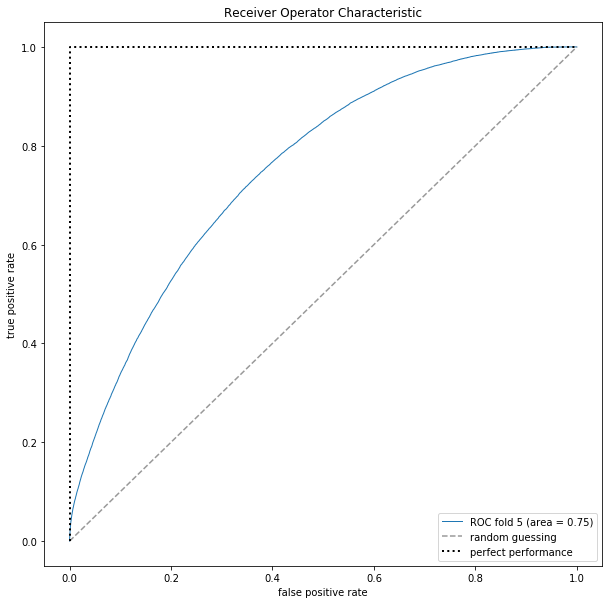

In [252]:
fpr, tpr, thresholds = roc_curve(Y, y_valid_pred, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.close()
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')
plt.plot([0, 0, 1], [0, 1, 1], lw=2, linestyle=':', color='black', label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC.png')
plt.show()

In [246]:
importances = sorted([(X.select_dtypes(include=['int64', 'float']).columns[i], imp) for i, imp in enumerate(imp_df.mean(axis=1))], key=lambda x: x[1])

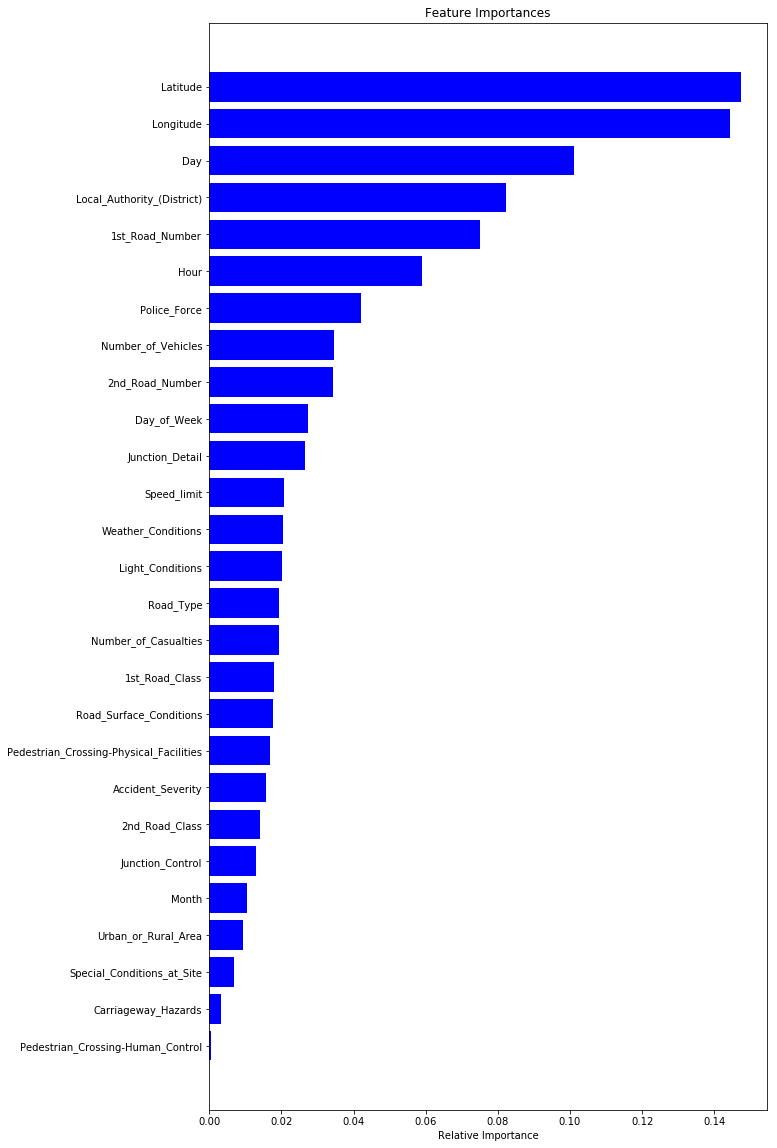

In [251]:
plt.close()
plt.figure(figsize=(10,20))
plt.title('Feature Importances')
plt.barh(range(len(importances)), [x[1] for x in importances], color='b', align='center')
plt.yticks(range(len(importances)), [x[0] for x in importances])
plt.xlabel('Relative Importance')
plt.savefig('importance.png')
plt.show()